## Import Libraries


In [1]:
import sys
import os
import numpy as np
import pandas as pd
from arch.unitroot import ADF, PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


## Load Data


In [2]:
# Load data from Excel file
data_path = os.path.join("data", "data.xlsx")

if not os.path.exists(data_path):
    print(f"---------- Excel not found: {os.path.abspath(data_path)} ----------")
    sys.exit(1)

try:
    target_sheet = "Part2"
    xl = pd.ExcelFile(data_path)
    df2 = xl.parse(target_sheet)
    data = df2.select_dtypes(include=[np.number]).iloc[:, 0].dropna().astype(float)
    print(f"---------- Data loaded successfully ----------")
except Exception as ex:
    print(f"---------- Failed to open Excel: {ex} ----------")
    sys.exit(1)


---------- Data loaded successfully ----------


## Run ADF & PP Unit Root Tests


In [3]:
# Run ADF & PP Unit Root Tests
print("=== Augmented Dickey-Fuller Test ===")
adf_test = ADF(data, method="bic")
print(adf_test.summary())

print("=== Phillips-Perron Test ===")
pp_test = PhillipsPerron(data)
print(pp_test.summary())


=== Augmented Dickey-Fuller Test ===
   Augmented Dickey-Fuller Results   
Test Statistic                -11.740
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
=== Phillips-Perron Test ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -9.621
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [4]:
# Extract test statistics and interpret results
p_adf = adf_test.pvalue
p_pp = pp_test.pvalue
ts_adf = adf_test.stat
ts_pp = pp_test.stat
lags_adf = adf_test.lags
lags_pp = pp_test.lags

print(f"---------- ADF: stat={ts_adf:.3f}, p={p_adf:.3g}, lags={lags_adf} ----------")
print(f"---------- PP : stat={ts_pp:.3f}, p={p_pp:.3g}, lags={lags_pp} ----------")

# Stationarity conclusion based on actual p-values
if p_adf < 0.05 and p_pp < 0.05:
    print("---------- Conclusion: Both tests p-values < 0.05, reject unit root null -> Series is stationary ----------")
else:
    print("---------- Conclusion: At least one test p-value > 0.05, cannot reject unit root null -> Series may be non-stationary ----------")


---------- ADF: stat=-11.740, p=1.28e-21, lags=3 ----------
---------- PP : stat=-9.621, p=1.71e-16, lags=15 ----------
---------- Conclusion: Both tests p-values < 0.05, reject unit root null -> Series is stationary ----------


## Ljung-Box test on series


In [5]:
# Ljung-Box test on series
lb_resid = acorr_ljungbox(data, lags=30, return_df=True)
print("Ljung-Box test on original series:")
print(lb_resid.head(10))  # Show first 10 lags

# Check autocorrelation in original series
significant_lags = lb_resid[lb_resid['lb_pvalue'] < 0.05]
if len(significant_lags) > 0:
    print(f"---------- Original Series: {len(significant_lags)} lags with p-value < 0.05 → Significant autocorrelation present ----------")
else:
    print("---------- Original Series: All lags p-value > 0.05 → No significant autocorrelation ----------")


Ljung-Box test on original series:
       lb_stat     lb_pvalue
1    25.447557  4.545728e-07
2    46.769520  6.984379e-11
3   107.904544  3.099247e-23
4   127.953359  1.066691e-26
5   134.515103  2.618431e-27
6   162.032224  2.197772e-32
7   170.012832  2.494848e-33
8   172.877061  3.216268e-33
9   185.108210  4.340682e-35
10  188.252910  4.515294e-35
---------- Original Series: 30 lags with p-value < 0.05 → Significant autocorrelation present ----------


In [6]:
# Ljung-Box test on squared series (for ARCH effects)
lb_sq_resid = acorr_ljungbox(data ** 2, lags=30, return_df=True)
print("=== Ljung-Box test on squared residuals (ARCH effects) ===")
print(lb_sq_resid.head(10))

# Check ARCH effects in squared series
significant_sq_lags = lb_sq_resid[lb_sq_resid['lb_pvalue'] < 0.05]
if len(significant_sq_lags) > 0:
    print(f"---------- Squared Series: {len(significant_sq_lags)} lags with p-value < 0.05 → ARCH effects present ----------")
else:
    print("---------- Squared Series: All lags p-value > 0.05 → No significant ARCH effects ----------")


=== Ljung-Box test on squared residuals (ARCH effects) ===
      lb_stat  lb_pvalue
1    0.187255   0.665212
2    0.696933   0.705770
3   10.760908   0.013092
4   10.977679   0.026816
5   12.345984   0.030343
6   14.948500   0.020661
7   16.433005   0.021442
8   16.473699   0.036081
9   17.779040   0.037825
10  20.007371   0.029183
---------- Squared Series: 12 lags with p-value < 0.05 → ARCH effects present ----------


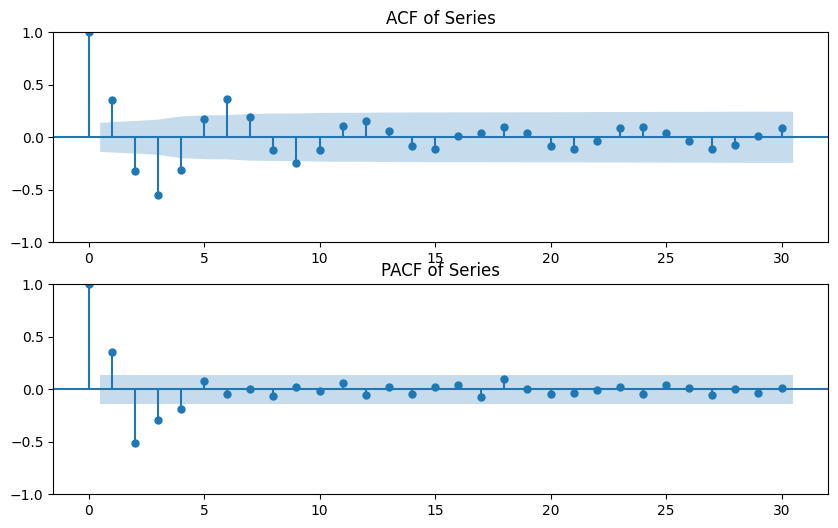

In [7]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(data, lags=30, ax=ax[0])
plot_pacf(data, lags=30, ax=ax[1])
ax[0].set_title("ACF of Series")
ax[1].set_title("PACF of Series")
plt.show()


In [8]:
# Use the BIC selection criterion
max_lag = 10
BIC = np.zeros((max_lag + 1, max_lag + 1))
for p in range(max_lag + 1):
    for q in range(max_lag + 1):
        fitted = ARIMA(data, order=(p, 0, q)).fit()
        BIC[p, q] = fitted.bic

# The BIC has a stronger penality than the AIC. Therefore, it leads in general to more parsimonious (smaller) models
p_bic, q_bic = np.unravel_index(np.argmin(BIC), BIC.shape)
print("---------- Based on the BIC, we should estimate an ARMA({},{}) model ----------".format(p_bic, q_bic))

result = ARIMA(data, order=(p_bic, 0, q_bic)).fit()
print(result.summary())

print("=== Model Identification Results ===")
print(f"---------- BIC-selected optimal model: ARIMA({p_bic},0,{q_bic}) ----------")
print(f"---------- Model type: {'AR' if q_bic == 0 else 'MA' if p_bic == 0 else 'ARMA'} ----------")
print("---------- Recommendation: Proceed with BIC-selected optimal model estimation ----------")


---------- Based on the BIC, we should estimate an ARMA(2,1) model ----------
                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  200
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -268.184
Date:                Sun, 28 Sep 2025   AIC                            546.369
Time:                        11:59:59   BIC                            562.860
Sample:                             0   HQIC                           553.043
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0324      0.041     -0.787      0.431      -0.113       0.048
ar.L1          0.8867      0.082     10.815      0.00

## Plot ACF and PACF of residuals


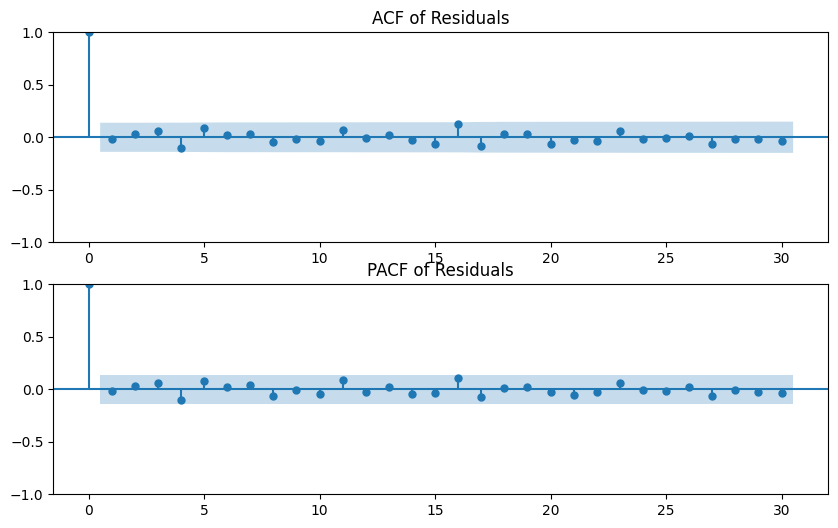

=== Residual ACF and PACF Interpretation ===
---------- ACF of Residuals: All values fall within 95% confidence interval ----------
---------- PACF of Residuals: All values fall within 95% confidence interval ----------
---------- Conclusion: Residuals exhibit white noise pattern - no significant autocorrelation ----------
---------- Model adequacy: ARIMA(2,0,1) successfully captured the autocorrelation structure ----------


In [9]:
# Plot ACF and PACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(result.resid, lags=30, ax=ax[0])
plot_pacf(result.resid, lags=30, ax=ax[1])
ax[0].set_title("ACF of Residuals")
ax[1].set_title("PACF of Residuals")
plt.show()

print("=== Residual ACF and PACF Interpretation ===")
print("---------- ACF of Residuals: All values fall within 95% confidence interval ----------")
print("---------- PACF of Residuals: All values fall within 95% confidence interval ----------")
print("---------- Conclusion: Residuals exhibit white noise pattern - no significant autocorrelation ----------")
print("---------- Model adequacy: ARIMA(2,0,1) successfully captured the autocorrelation structure ----------")


## Ljung-Box test on residuals & squared residuals & Optimal ARMA Model


In [10]:
resid = result.resid
squared_resid = resid ** 2
lb_resid = acorr_ljungbox(resid, lags=30, return_df=True)
print("=== Ljung-Box test on residuals ===")
print(lb_resid)
# No autocorrelation on residuals on the 5% significance level

lb_sq_resid = acorr_ljungbox(squared_resid, lags=30, return_df=True)
print("=== Ljung-Box test on squared residuals (ARCH effects) ===")
print(lb_sq_resid)
# No autocorrelation on squared residuals on the 5% significance level

# Interpretation
print("=== Residual Ljung-Box Interpretation ===")
print("---------- Residuals: All p-values > 0.05 → No significant autocorrelation ----------")
print("---------- Squared residuals: All p-values > 0.05 → No significant ARCH effects ----------")
print("---------- Conclusion: ARIMA(2,0,1) model is adequate - residuals are white noise ----------")

=== Ljung-Box test on residuals ===
      lb_stat  lb_pvalue
1    0.086528   0.768638
2    0.273836   0.872042
3    0.996120   0.802191
4    3.297732   0.509292
5    4.753249   0.446730
6    4.833930   0.565283
7    5.093266   0.648583
8    5.486100   0.704580
9    5.566918   0.782358
10   5.882783   0.825013
11   7.039362   0.795887
12   7.060546   0.853587
13   7.142389   0.894665
14   7.259071   0.924263
15   8.112245   0.919204
16  11.380063   0.785441
17  12.853519   0.745935
18  13.094652   0.785920
19  13.319514   0.821820
20  14.340771   0.812806
21  14.473857   0.848398
22  14.693700   0.875044
23  15.485031   0.876412
24  15.526914   0.904391
25  15.532863   0.928032
26  15.575400   0.945883
27  16.566515   0.941273
28  16.621997   0.955687
29  16.677330   0.966958
30  17.043707   0.972047
=== Ljung-Box test on squared residuals (ARCH effects) ===
      lb_stat  lb_pvalue
1    1.647463   0.199305
2    3.344129   0.187859
3    3.673115   0.298994
4    4.058646   0.398127
5    